In [2]:
import os
import socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import Bucketizer, QuantileDiscretizer
from pyspark.sql import Window

In [3]:
try:
    spark
except NameError:
    spark = SparkSession.builder.appName("").getOrCreate()

In [44]:
# Local
if 'samuel' in socket.gethostname().lower():
    path_to_data = '../../data'
# Cluster
else:
    path_to_data = '/user/spf248/twitter/data'
print('Path to data:',path_to_data) 
country_code = "US"
print('Country:', country_code)
iterations=range(2)
models=['GLOVE','BERT']
labels=['is_hired_1mo', 'is_unemployed', 'job_offer', 'job_search', 'lost_job_1mo']
keywords=['fired', 'hired', 'job', 'laid_off', 'position', 'quit', 'unemployed', 'work']
targets=[
'target_anyone_hiring',
'target_here_is_a_job_opportunity_you_might_be_interested_in',
'target_i_am_currently_not_working',
'target_i_am_searching_for_a_new_position',
'target_i_got_hired_today',
'target_i_lost_my_job_today',
'target_i_recently_started_working_at_my_new_job',
'target_i_was_fired_earlier_this_week',
'target_looking_for_a_new_position',
'target_now_i_am_unemployed']

base_rates=[
1.7342911457049017e-05,
0.0003534645020523677,
0.005604641971672389,
0.00015839552996469054,
1.455338466552472e-05]
N_random=92114009
n=int(np.ceil(np.log10(N_random)))
base_ranks=[int(x*N_random) for x in base_rates]
label2rank=dict(zip(labels,base_ranks))

Path to data: ../../data
Country: US


In [ ]:
random_tweets=spark.read.parquet(os.path.join(path_to_data,'classification',country_code,'random-scored'))
for keyword in keywords:
    random_tweets=random_tweets.withColumn(keyword,F.col(keyword).cast('integer'))
random_tweets.cache()

In [ ]:
# df=random_tweets.select(*keywords)
# for keyword in keywords:
#     df=df.withColumn(keyword,F.col(keyword).cast('integer'))
# df=df.groupby().mean().select(*['avg('+x+')' for x in keywords])
# df=df.toDF(*(col.replace('avg(','').replace(')','') for col in df.columns))
# df.coalesce(1).write.mode("overwrite").option("header", "true").csv(os.path.join(path_to_data,'classification',country_code,'base_rates_keywords'))

In [ ]:
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            predictions=spark.read.option("header", "true").csv(os.path.join(path_to_data,'classification',country_code,'predictions','iteration_'+str(iteration),model,label,'random*'))
            predictions=predictions.withColumnRenamed('proba','score').withColumnRenamed('second','score').select('tweet_id','score')
            predictions=predictions.withColumn('score',F.col('score').cast('float'))
            df=predictions.join(random_tweets,on='tweet_id')
            df=df.withColumn("score_rank", F.row_number().over(Window.orderBy(F.desc("score"))))
            # Split in logspace then increase the number of points among the low ranks 
            splits=sorted(set([x for i in range(n) for x in np.logspace(i,i+1,i+1)]))
            bucketizer=Bucketizer(splits=splits,inputCol="score_rank", outputCol="score_rank_bucket")
            df=bucketizer.setHandleInvalid("keep").transform(df)
            df=df.select(keywords+targets+['score_rank_bucket',"score_rank"])
            df=df.groupby('score_rank_bucket').agg(dict((x,'mean') for x in ["score_rank"]+keywords+targets))
            df=df.toDF(*(col.replace('avg(','').replace(')','') for col in df.columns))
            df.coalesce(1).write.mode("overwrite").option("header", "true").csv(os.path.join(path_to_data,'classification',country_code,'evaluation','iteration_'+str(iteration),model,label))

# Figures

In [11]:
df={}
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            name='iteration_'+str(iteration)+'-'+model+'-'+label
            df[name]=spark.read.option("header", "true").csv(os.path.join(path_to_data,'classification',country_code,'evaluation','iteration_'+str(iteration),model,label)).toPandas().astype(float)


********* Iteration: 0 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

********* Iteration: 1 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***

****** Model: BERT ******
*** Label: is_hired_1mo ***
*** Label: is_unemployed ***
*** Label: job_offer ***
*** Label: job_search ***
*** Label: lost_job_1mo ***


In [12]:
label2targets=dict(zip(labels,[
['target_i_got_hired_today',
'target_i_recently_started_working_at_my_new_job'],
['target_now_i_am_unemployed',
'target_i_am_currently_not_working'],
['target_looking_for_a_new_position',
'target_here_is_a_job_opportunity_you_might_be_interested_in'],
['target_anyone_hiring',
'target_i_am_searching_for_a_new_position',
],
['target_i_lost_my_job_today',
'target_i_was_fired_earlier_this_week'],
]))

In [13]:
label2targets

{'is_hired_1mo': ['target_i_got_hired_today',
  'target_i_recently_started_working_at_my_new_job'],
 'is_unemployed': ['target_now_i_am_unemployed',
  'target_i_am_currently_not_working'],
 'job_offer': ['target_looking_for_a_new_position',
  'target_here_is_a_job_opportunity_you_might_be_interested_in'],
 'job_search': ['target_anyone_hiring',
  'target_i_am_searching_for_a_new_position'],
 'lost_job_1mo': ['target_i_lost_my_job_today',
  'target_i_was_fired_earlier_this_week']}

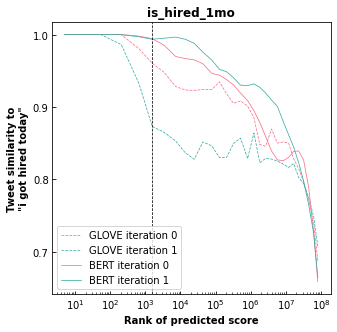

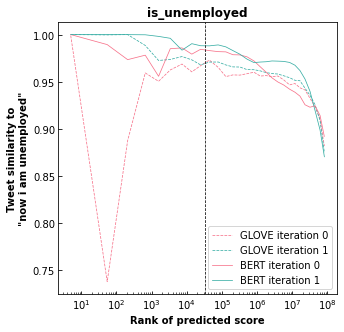

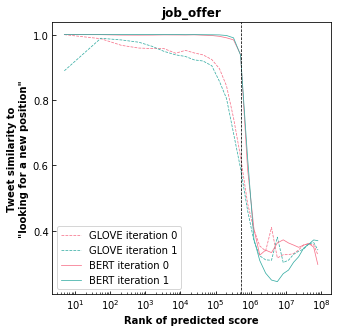

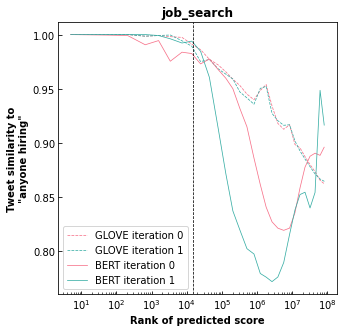

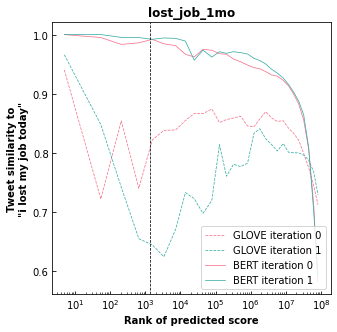

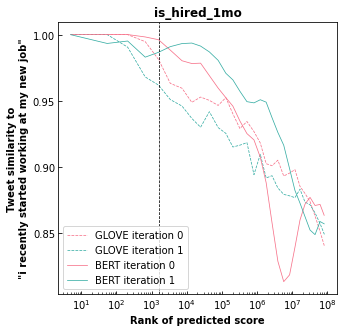

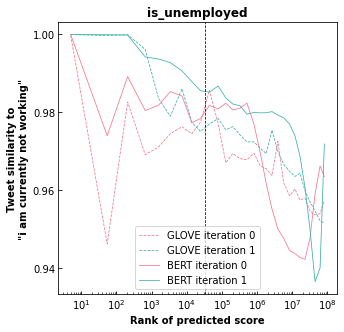

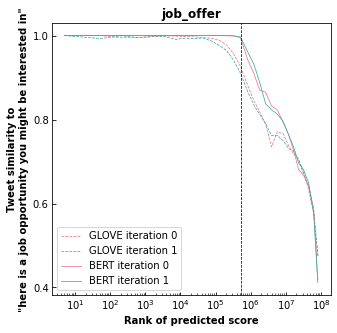

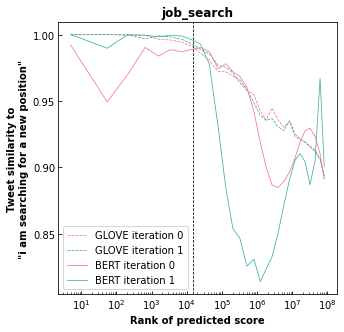

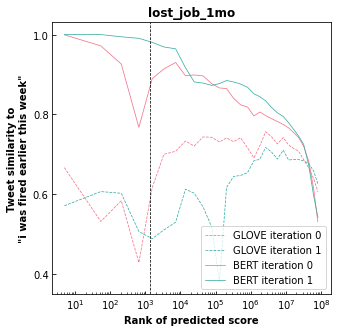

In [49]:
for target_index in [0,1]:
    for label in labels:
        target_sentence=label2targets[label][target_index]
        fig,ax = plt.subplots(figsize=(5,5))
        for i,model in enumerate(models):
            for j,iteration in enumerate(iterations):
                name='iteration_'+str(iteration)+'-'+model+'-'+label
                df[name].plot(y=target_sentence,
                              x='score_rank',
                              ax=ax,
                              linewidth=.75,
                              color=sns.color_palette("husl", len(models))[j],
                              style=['--','-'][i],
                              label=model+' iteration '+str(iteration))
        ax.axvline(label2rank[label],linewidth=.75,color='k',linestyle='--')
        ax.set_xscale('log')
        ax.tick_params(which='both',direction='in',pad=3)
        ax.locator_params(axis='y',nbins=6)
        ax.set_ylabel('Tweet similarity to\n"'+target_sentence.replace('target_','').replace('_',' ')+'"',fontweight='bold')
        ax.set_xlabel('Rank of predicted score',fontweight='bold')
        ax.set_title(label,fontweight='bold')
        ax.legend(loc='best')
        plt.savefig(os.path.join(path_to_data,'../fig','pred_target_sent_'+str(target_index)+'_sim_'+label+'.pdf'),bbox_inches='tight')

/Users/samuelfraiberger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/samuelfraiberger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/samuelfraiberger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than

/Users/samuelfraiberger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


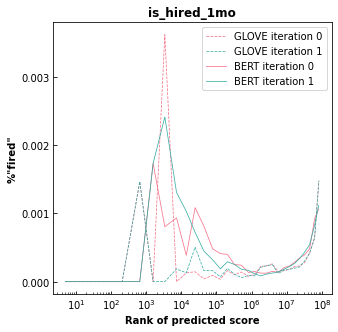

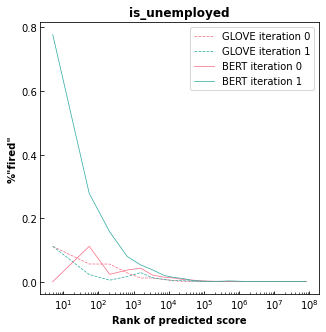

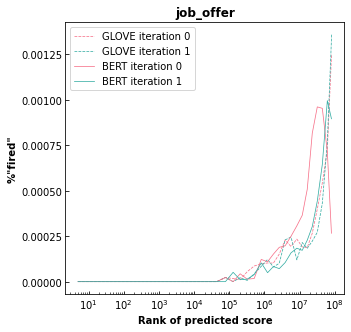

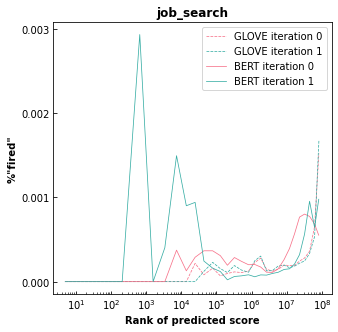

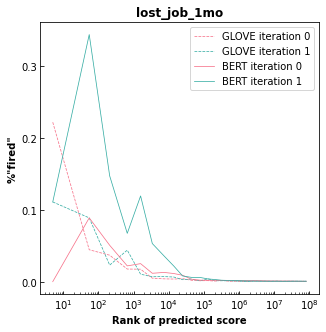

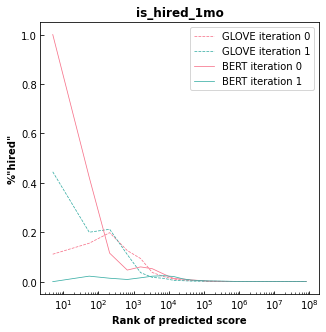

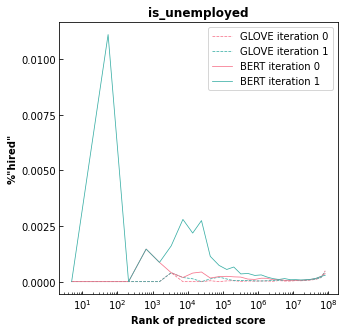

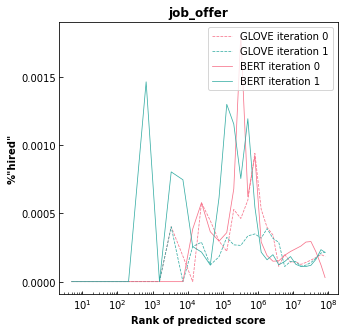

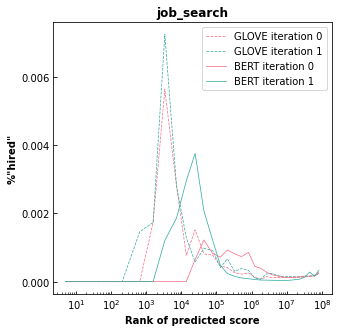

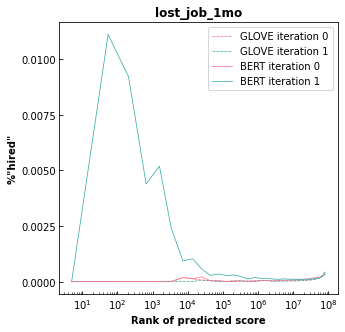

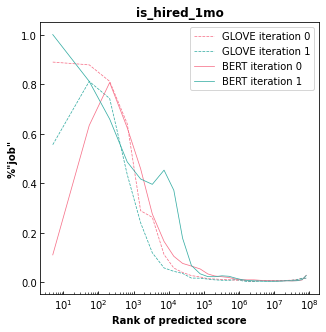

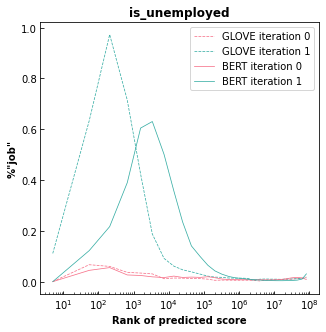

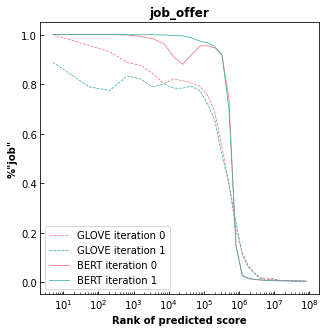

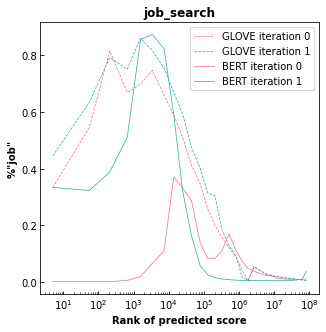

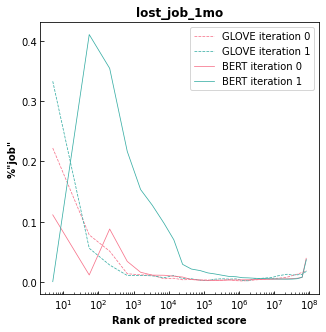

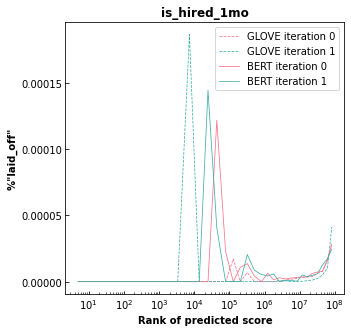

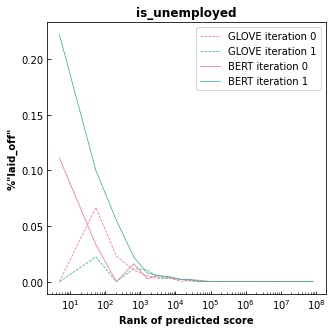

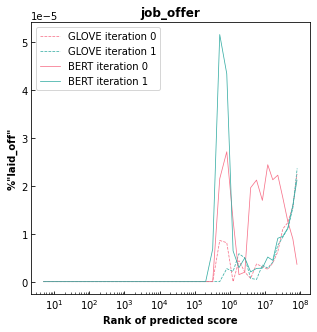

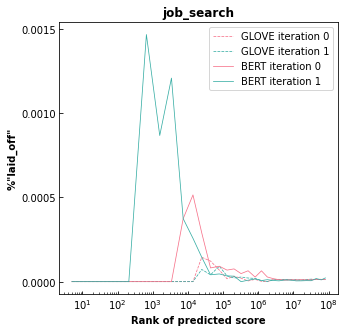

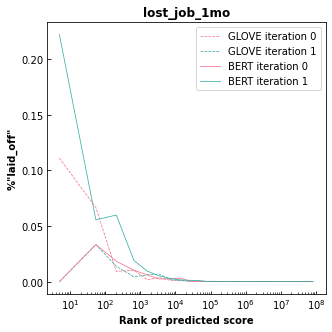

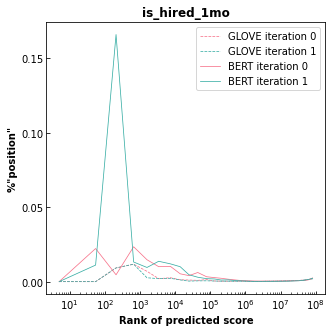

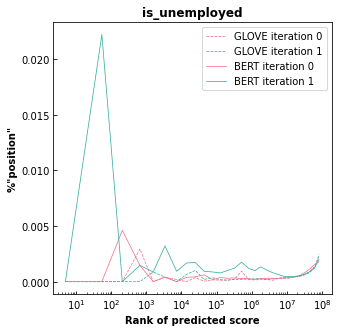

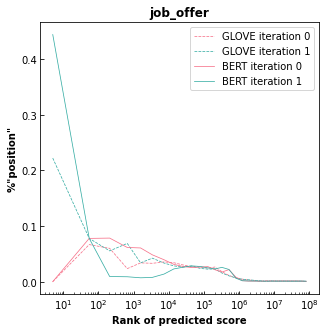

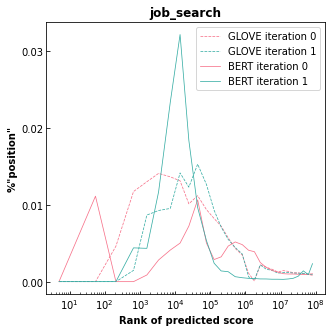

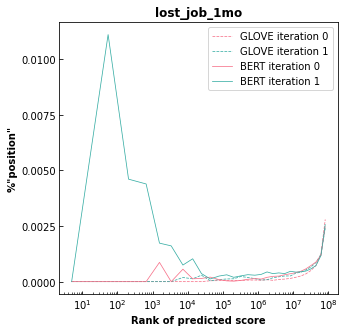

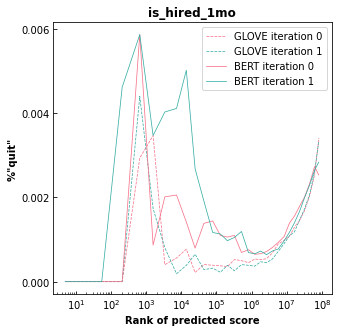

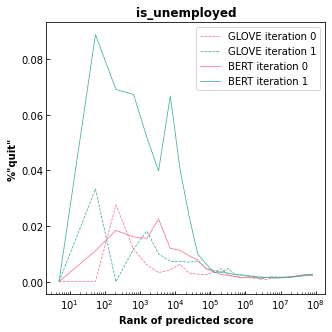

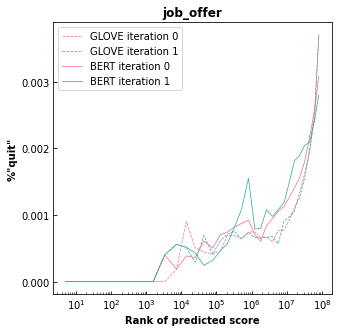

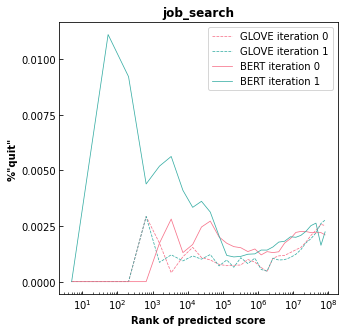

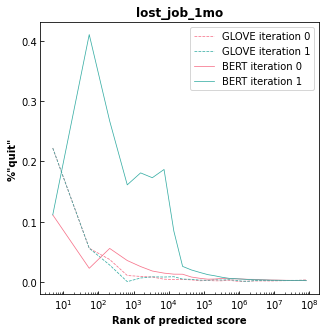

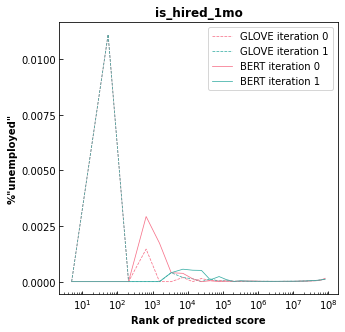

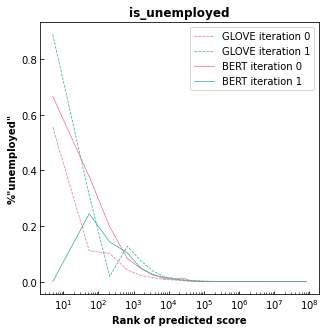

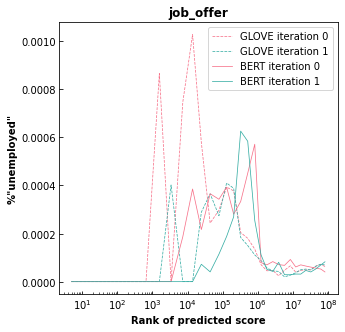

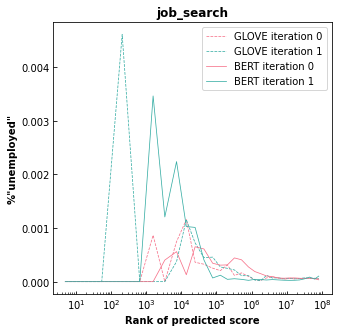

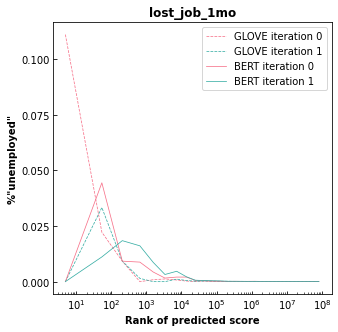

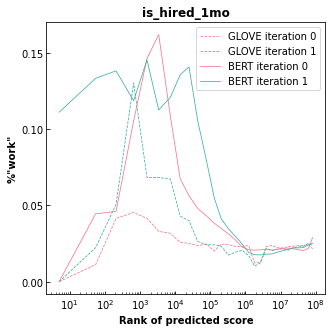

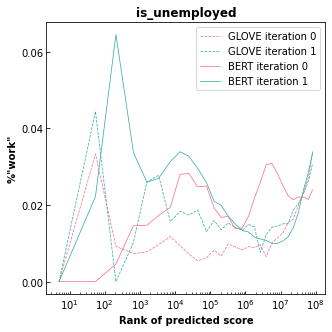

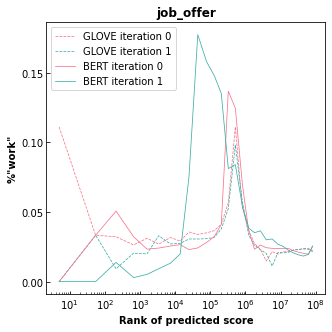

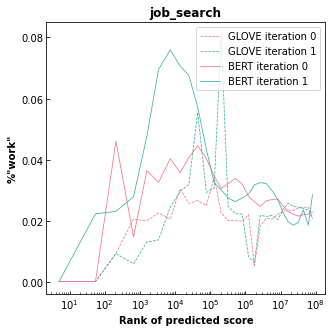

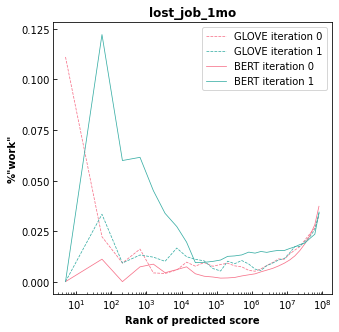

In [43]:
for keyword in keywords:
    for label in labels:
        fig,ax = plt.subplots(figsize=(5,5))
        for i,model in enumerate(models):
            for j,iteration in enumerate(iterations):
                name='iteration_'+str(iteration)+'-'+model+'-'+label
                df[name].plot(y=keyword,
                              x='score_rank',
                              ax=ax,
                              linewidth=.75,
                              color=sns.color_palette("husl", len(models))[j],
                              style=['--','-'][i],
                              label=model+' iteration '+str(iteration))
        ax.set_xscale('log')
        ax.tick_params(which='both',direction='in',pad=3)
        ax.locator_params(axis='y',nbins=6)
        ax.set_ylabel('%"'+keyword+'"',fontweight='bold')
        ax.set_xlabel('Rank of predicted score',fontweight='bold')
        ax.set_title(label,fontweight='bold')
        ax.legend(loc='best')
        plt.savefig(os.path.join(path_to_data,'../fig','pred_'+keyword+'_'+label+'.pdf'),bbox_inches='tight')